In [1]:
import os
from pathlib import Path
import IPython.display as ipd

import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
%matplotlib inline
import re
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [2]:
# read each wav file convert into a spectogram and flatten it as x
# read and the corresponding label and convert into one hot encoding as Y
# Baseline : Start with DNN classifier with  two hidden layesr and drop out as regularization at each step
# output layer  10 neurons for classification at output.
# Once the wave forms are converted, its akin to image comparison 
# MLP Model can be like a baseline.
# we will have to compare against performance using  CNNs , and also AUTOENCODERS.

#TODO - Use confusion matrix and validate how confused are the classification.
#TODO - remove any outliers in data input. 

AUDIO_PATH = 'Documents/data_speech_commands_v0.02/'
LABELS = ['eight', 'five', 'four', 'one',  'seven', 'six', 'three', 'two', 'zero', 'nine']


In [3]:
#Original sound wav - we cant use as its highly random wav and difficult to identify pattern
#Many options - convert to spectogram / or more advanced : Mel-frequency cepstral coefficients (MFCCs) 
#current implementation is for spectogram .

#convert into spectograms : look at how the actual wav form it is 

sample_rate1, samples1 = wavfile.read(str(AUDIO_PATH) + '/zero/0a2b400e_nohash_0.wav')
sample_rate2, samples2 = wavfile.read(str(AUDIO_PATH) + '/one/0a2b400e_nohash_0.wav')
sample_rate3, samples3 = wavfile.read(str(AUDIO_PATH) + '/two/0a2b400e_nohash_0.wav')
frequencies1, times1, spectogram1 = signal.spectrogram(samples1, sample_rate1)
frequencies2, times2, spectogram2 = signal.spectrogram(samples2, sample_rate2)
frequencies3, times3, spectogram3 = signal.spectrogram(samples3, sample_rate3)



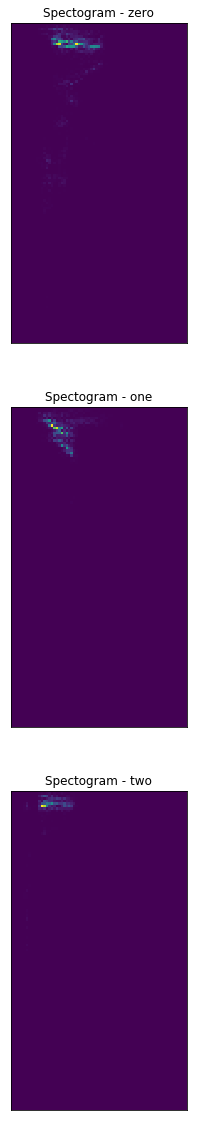

In [6]:
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(311)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Spectogram - zero')
ax1.imshow(spectogram1)

ax2 = fig.add_subplot(312)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Spectogram - one')
ax2.imshow(spectogram2)

ax2 = fig.add_subplot(313)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Spectogram - two')
ax2.imshow(spectogram3)

#OBSERVATION : 
#Can see that half the time series is with silence and the clippings could be clipped for dimension reduction
#

In [7]:
# reading files with only (0 -9) for simplicity, 
# lets neglect other wav files .
# TODO  add more classification such as silence, unknown for other input waves.
# DATASET USED 
# https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data
#data set downloaded locally  under relative path /Documents/data_speech_commands_vo.02


# for each label , read the training and validation files and corresponding target label 
def create_list_of_validation_files():

    fp = open(AUDIO_PATH + "validation_list.txt", 'r')
    line = fp.readline()
    cnt = 1
    validation_file_list =[]
    while line:
       validation_file_list.append(line.strip())
       line = fp.readline()
    return validation_file_list


#CREATE INPUT TRAIN AND VALIDATION DATA SET
#TODO - DIMENSION REDUCTION BY CLIPPING SILENCE( can see more shorter clips)
#TODO - DIMENSION REDUCTION BY Resampling 
#TODO - DATA AUGMENTATION BY ADDING NOISE AND CREATE NEW SOUND CLIPS 

def create_input(validation_file_list):

    filecount = 0
    wavefiles = []
    #using lists instead of numpy array for faster reading while loop 
    X_train = []
    X_validation = []
    y_train= []
    y_validation = []
    for  label in LABELS:
        #read each file under train_label and convert it into histogram assign to first ,
        #assign label 
        wavefile = glob.glob(AUDIO_PATH  + label + "/*.wav")
        for wav in wavefile:
            sample_rate, samples = wavfile.read(wav)
            frequencies, times, spectogram = signal.spectrogram(samples, sample_rate)
            filename = re.split(AUDIO_PATH , wav)
            if(len(times)==71): 
                #currently reading only similar length file
                #TODO IMPROVE BY PADDING IF FILE LENGTH IS LESS OR CLIP IF MORE 
                try:
                    if(filename[1] in validation_file_list): 
                        X_validation.append(np.array(spectogram))
                        y_validation.append(label)
                    else:
                        X_train.append(np.array(spectogram))
                        y_train.append(label)
                except:
                     pass 
    return X_train, y_train,X_validation, y_validation





In [8]:
validation_list = create_list_of_validation_files()
# get all the files that needs to be in validation test data set, so we can correctly split the wav forms

In [9]:
X_train,y_train,X_validation, y_validation = create_input(validation_list)
print(len(X_train), len(y_train), len(X_validation), len(y_validation))

32293 32293 3338 3338


In [10]:
X_Train = np.asarray(X_train)
y_Train = np.asarray(y_train)
X_Validation = np.asarray(X_validation)
y_Validation = np.asarray(y_validation)


# FIRST LABEL ENCODE AND ONE HOT ENCODE FOR CATEGORICAL OUTPUT TO FEED TO NEURAL NW

label_encoder = LabelEncoder()
label_encoder.fit(y_Train)
y_Train = label_encoder.transform(y_Train.reshape(-1,1))
y_Validation = label_encoder.transform(y_Validation.reshape(-1,1))
onehot_encoder = OneHotEncoder(sparse=False)
y_Train = onehot_encoder.fit_transform(y_Train.reshape(-1,1))
y_Validation = onehot_encoder.transform(y_Validation.reshape(-1,1))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
#FLATTEN INPUT ARRAYS
X_Train = X_Train.reshape(32293, 129*71)
X_Validation = X_Validation.reshape(3338, 129*71)
 INPUT_SHAPE = 129*71

In [12]:
#normalize inputs, we take log of values to have much reasonable scale between frequencies
# check for other custom built libraries which could do logarithmic transform to give more weightage to frequency range of interest

X_Train = np.log(X_Train+ 1e-10) # add small error to avoid  infinity. 
print(np.min(X_Train), np.max(X_Train))
from sklearn.preprocessing import MinMaxScaler
X_Train = MinMaxScaler().fit_transform(X_Train)
print(np.min(X_Train), np.max(X_Train))


-23.02585 16.335938
0.0 1.0000001


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

EPOCHS = 20 # ideally need to run for longer epoch 
BATCHSIZE = 16

model = Sequential()
model.add(Dense(512,  kernel_initializer='TruncatedNormal',activation='relu', input_shape=(INPUT_SHAPE,)))
model.add(Dropout(0.2))
model.add(Dense(128,  kernel_initializer='TruncatedNormal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, kernel_initializer='TruncatedNormal', activation='softmax')) 
#SINCE WE WANT OUTPUT TO BE PROBABILITY OF PREDICTION TO PARTICULAR CLASS, use softmax activation at output
model.summary()

model.compile(loss='categorical_crossentropy', # ITS CLASSIFICATION PROBLEM 
              optimizer='adam', # CAN VARY OPTIMIZER for baseline , adam is selected.  
              metrics=['accuracy']) # TODO check for confidence ( probablity of top three prediction class difference etc) 

history = model.fit(X_Train, y_Train,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_Validation, y_Validation)) 

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4689920   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 4,756,874
Trainable params: 4,756,874
Non-trainable params: 0
_________________________________________________________________
Train on 32293 samples, validate on 3338 samples
Epoch 1/20
32293/32293 [==============================] - 172s 5ms/step - loss: 2.3

In [ ]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()